In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

In [6]:
import graphufs
from graphufs.utils import open_zarr, open_dataset

plt.style.use("graphufs.plotstyle")

In [7]:
gds = []
for latent_size in [16, 64, 128, 256]:
    gds.append(
        open_zarr(
            f"/testlfs/latent-size-test-{latent_size:03d}/evaluation/long-forecast/graphufs.2019-01-01T00.2154h.zarr/"
        ).expand_dims({
            "latent_size": [latent_size],
        })
    )
gds = xr.concat(gds, dim="latent_size")

In [8]:
errors = []
for latent_size in [16, 64, 128, 256]:
    errors.append(
        open_dataset(
            f"/testlfs/latent-size-test-{latent_size:03d}/evaluation/validation/graphufs_vs_replay_240h_deterministic_spatial.nc"
        ).expand_dims({
            "latent_size": [latent_size],
        })
    )
errors = xr.concat(errors, dim="latent_size")

In [20]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr",
    storage_options={"token": "anon"},
)
era = era.sel(
    time=slice(
        pd.Timestamp(gds.time.isel(time=0).values) - pd.Timedelta(hours=24),
        gds.time.isel(time=-1).values
    ),
)

In [10]:
rds = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"token":"anon"},
)
rds = rds[[x for x in gds.data_vars]]
rds = rds.rename({
    "grid_xt": "lon", 
    "grid_yt": "lat",
    "pfull": "level",
})
rds = rds.sel(level=gds.level.values)

In [11]:
from graphufs.spatialmap import SpatialMap

In [12]:
mapper = SpatialMap()

## Spatial Error

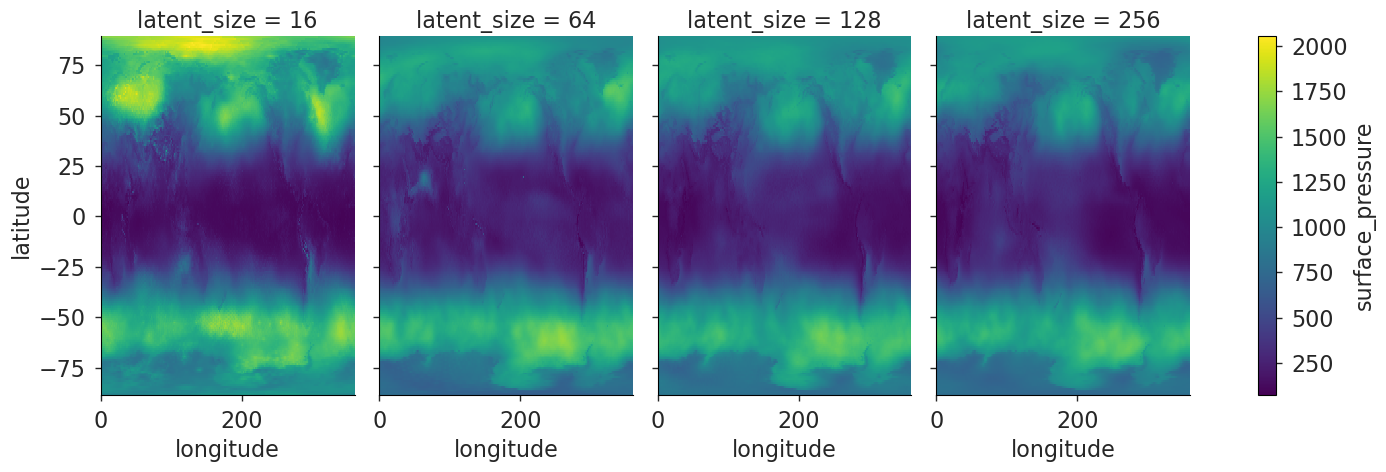

In [13]:
errors.surface_pressure.sel(
    metric="mae",
    fhr=24*9,
).plot(
    col="latent_size",
    figsize=(15,5),
)

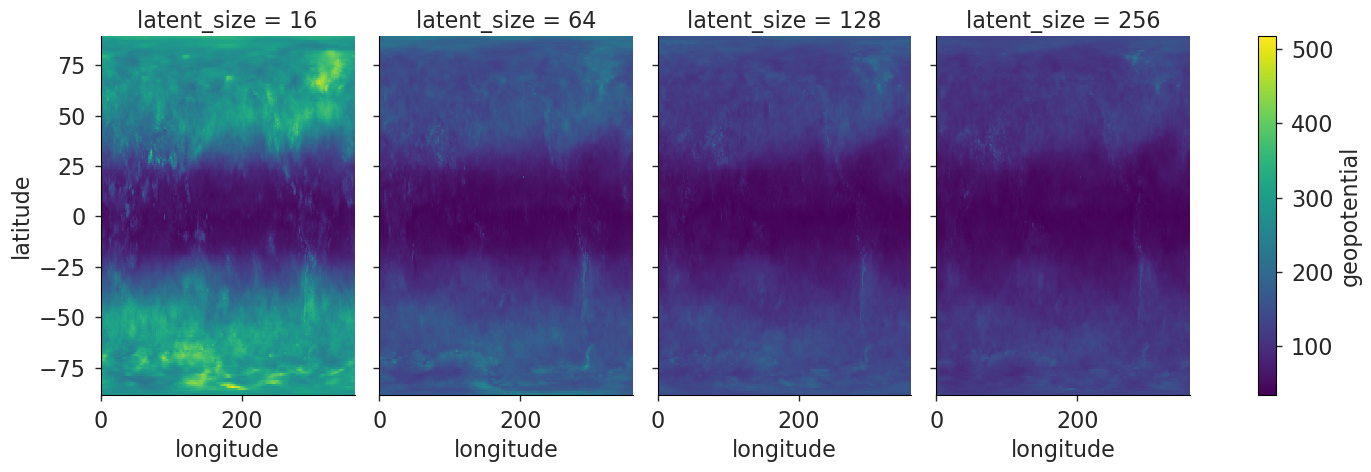

In [15]:
errors.geopotential.sel(
    level=500,
    method="nearest",
).sel(
    metric="mae",
    fhr=24,
).plot(
    col="latent_size",
    figsize=(15,5),
)

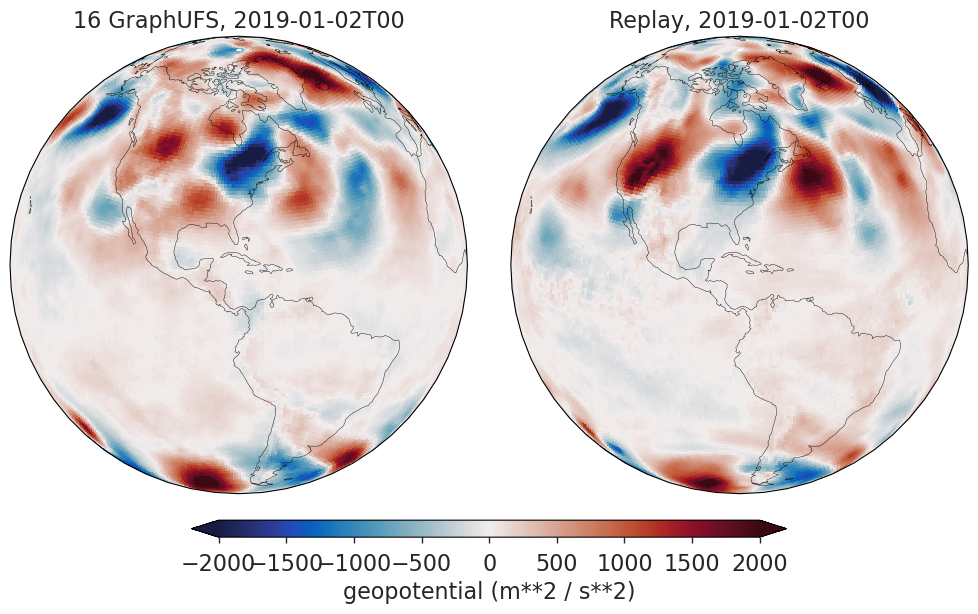

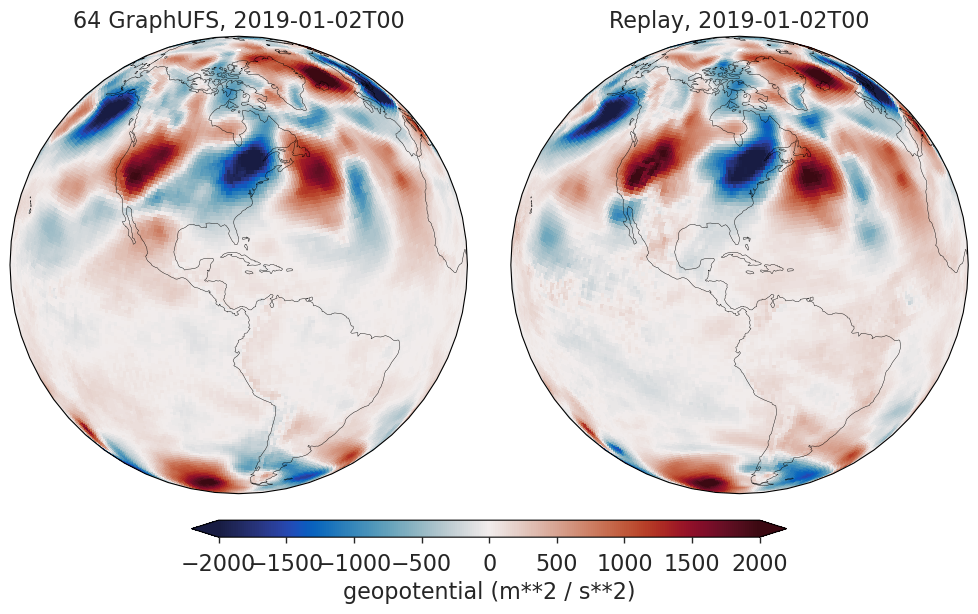

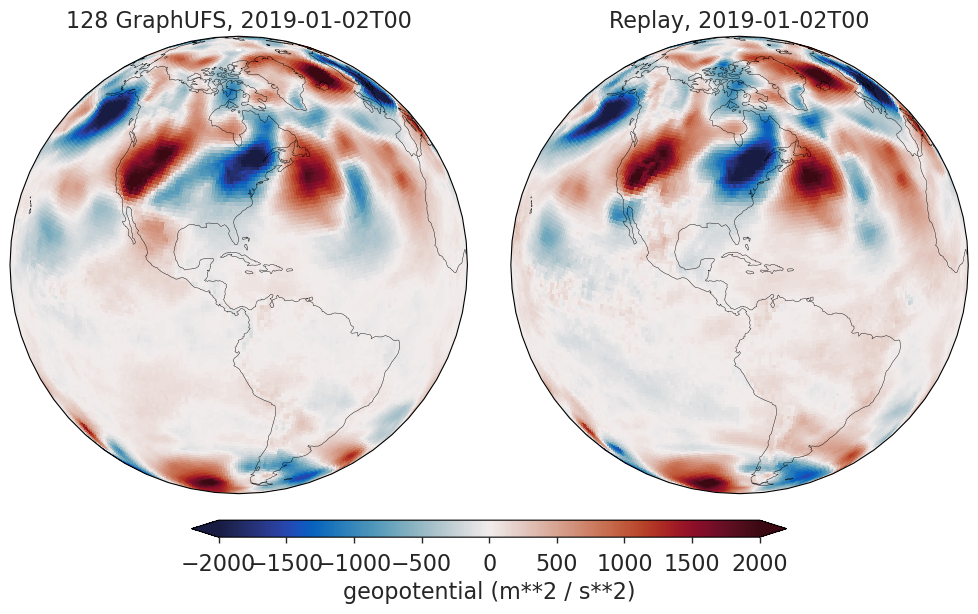

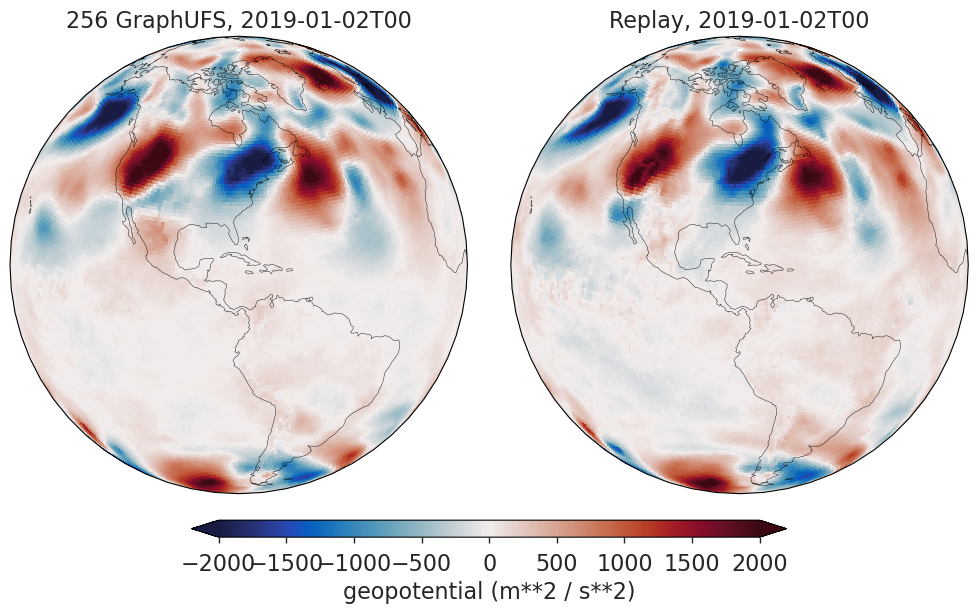

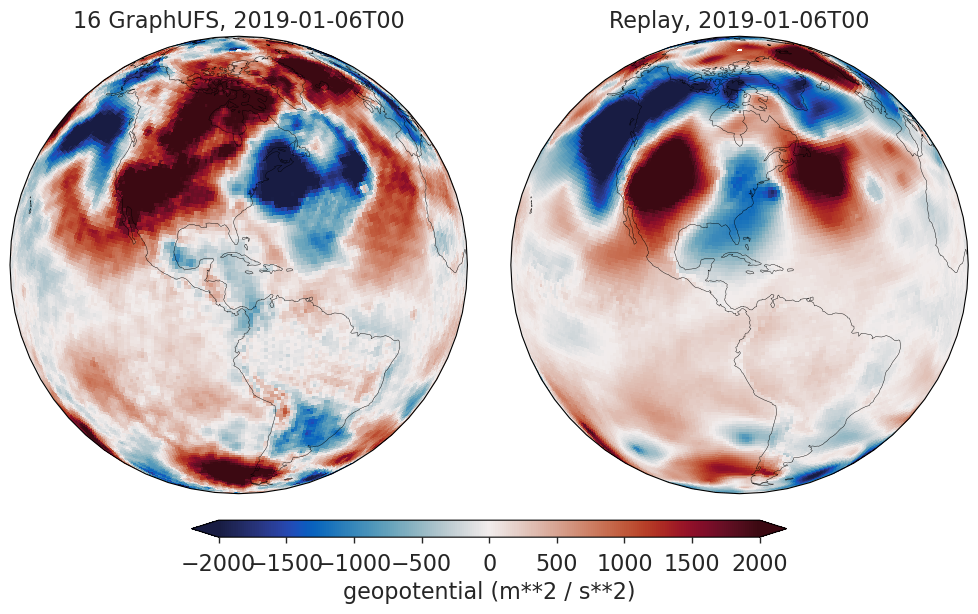

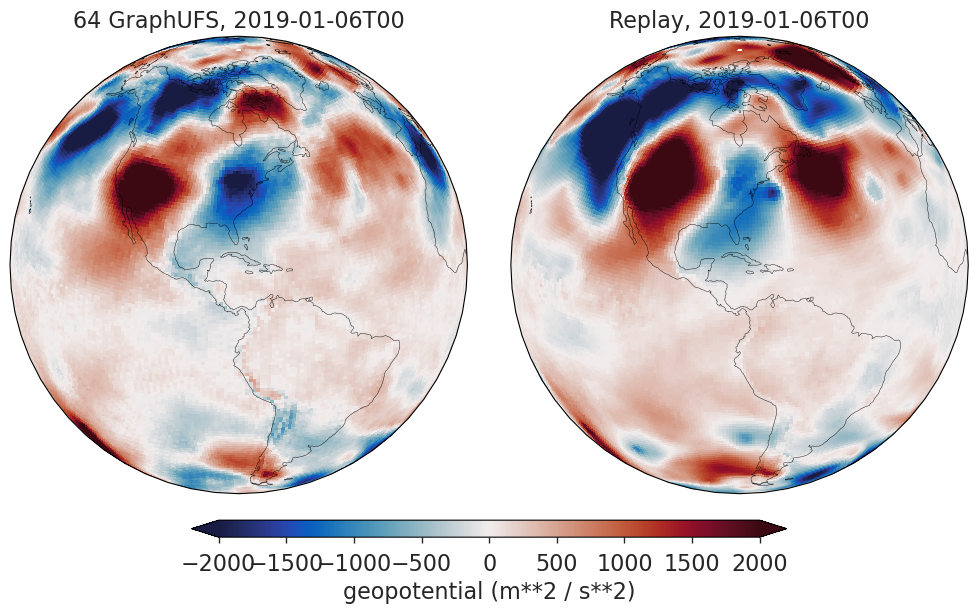

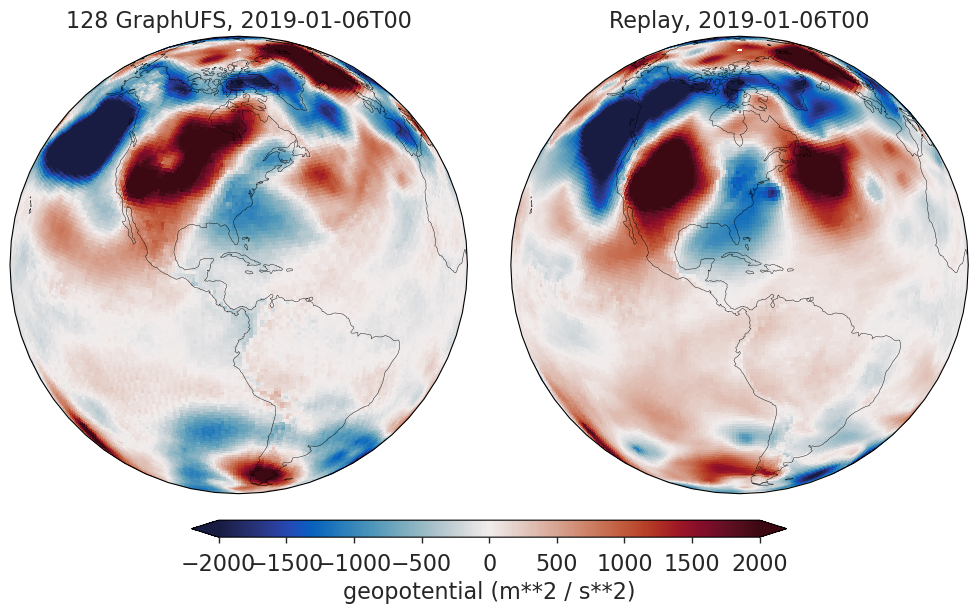

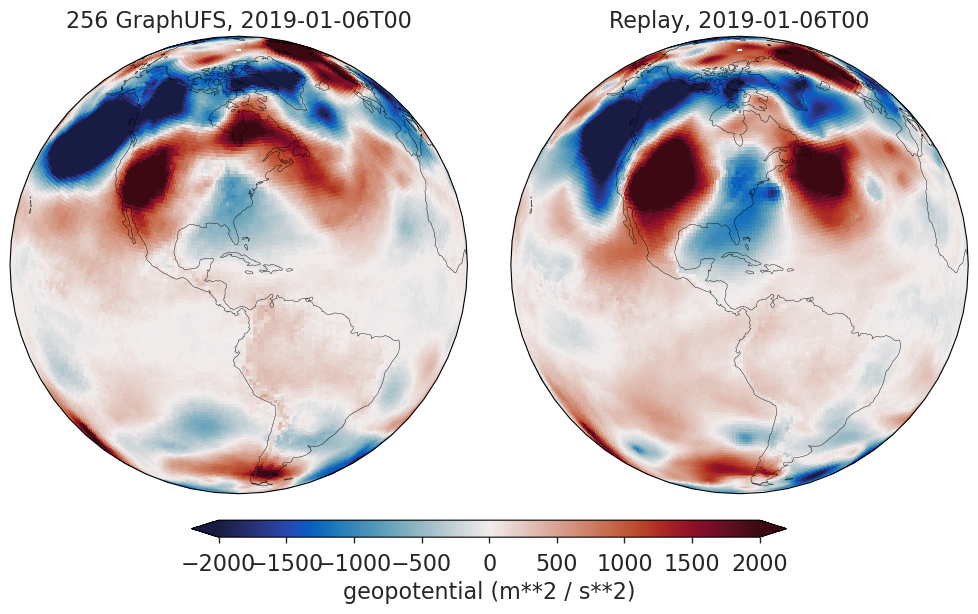

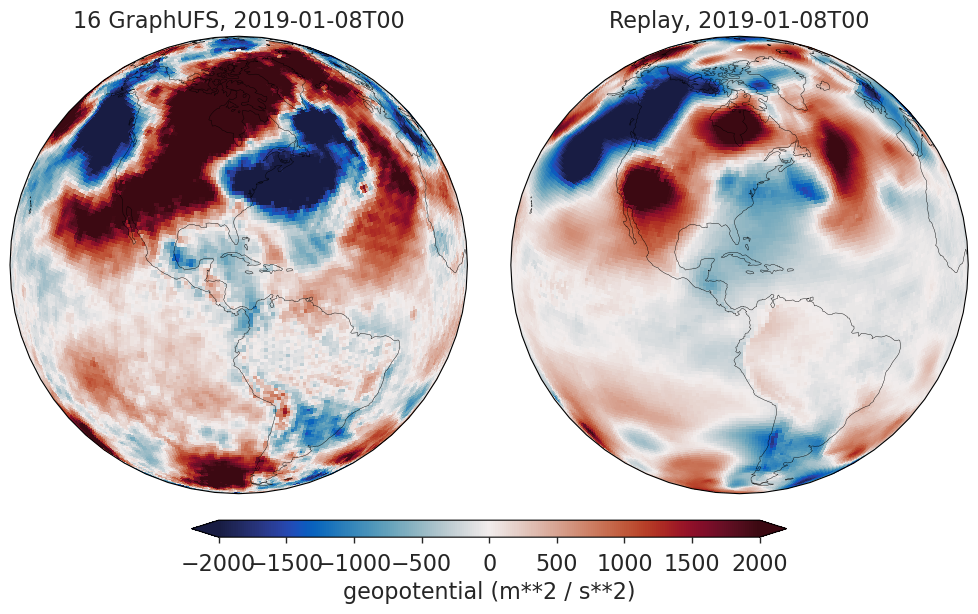

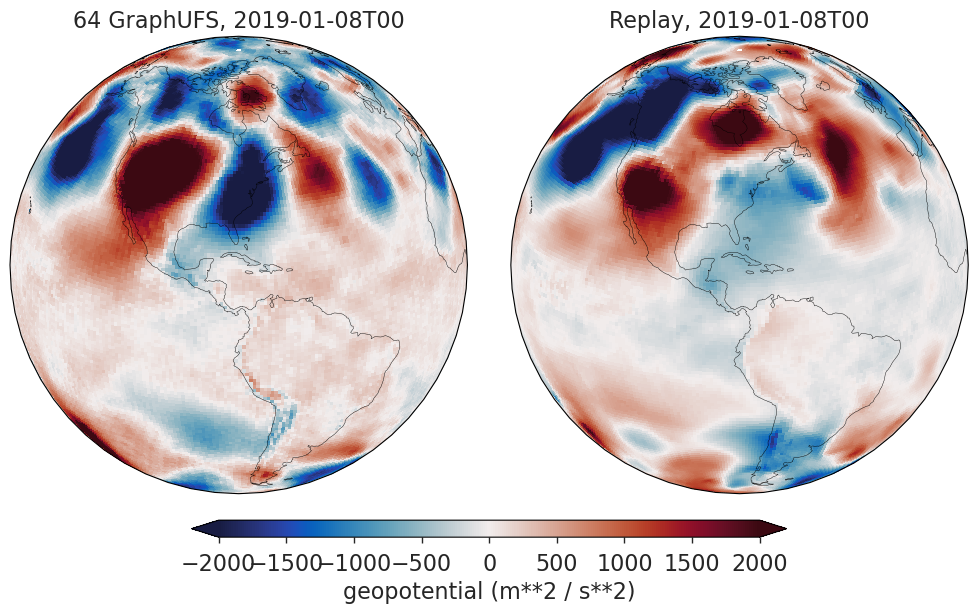

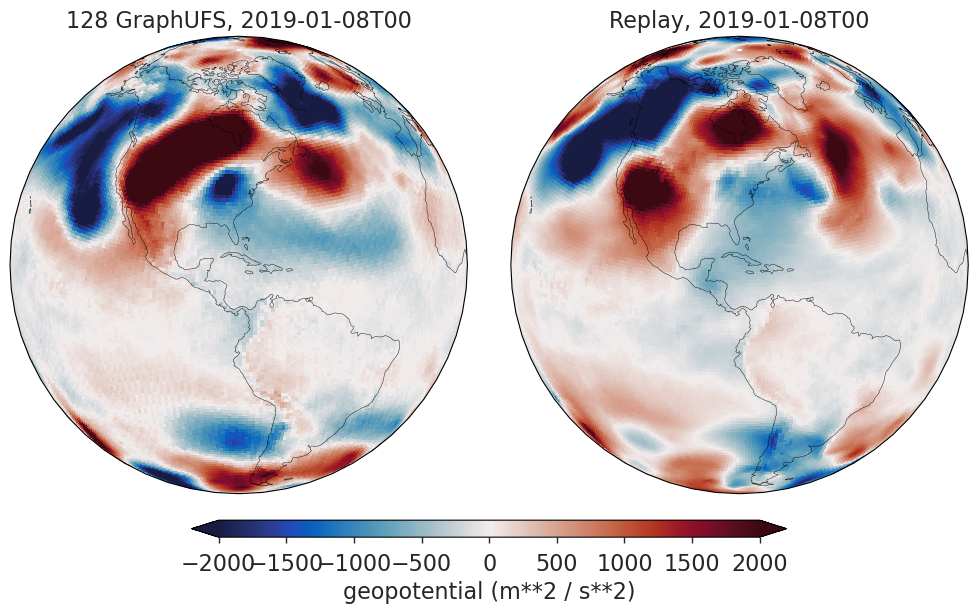

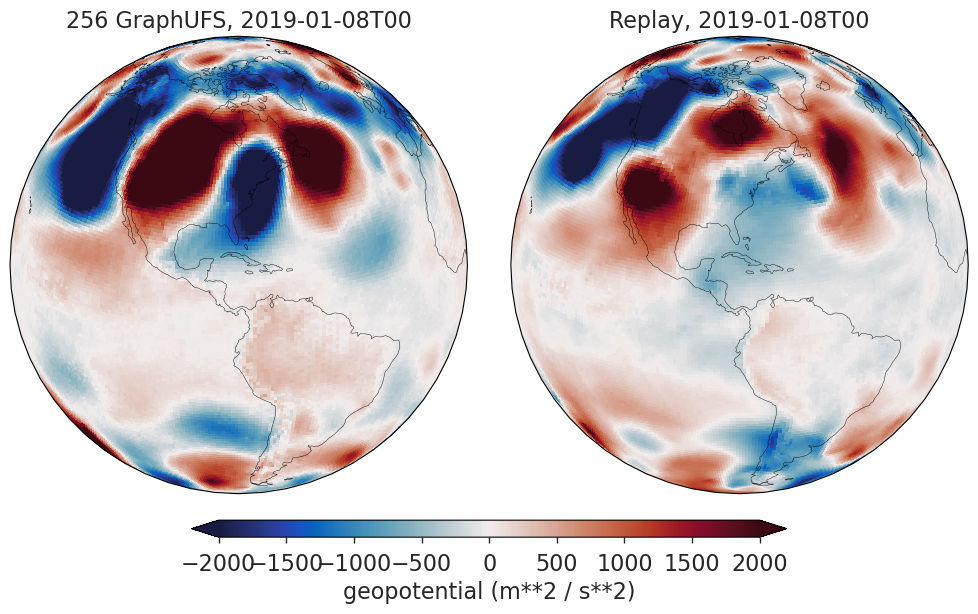

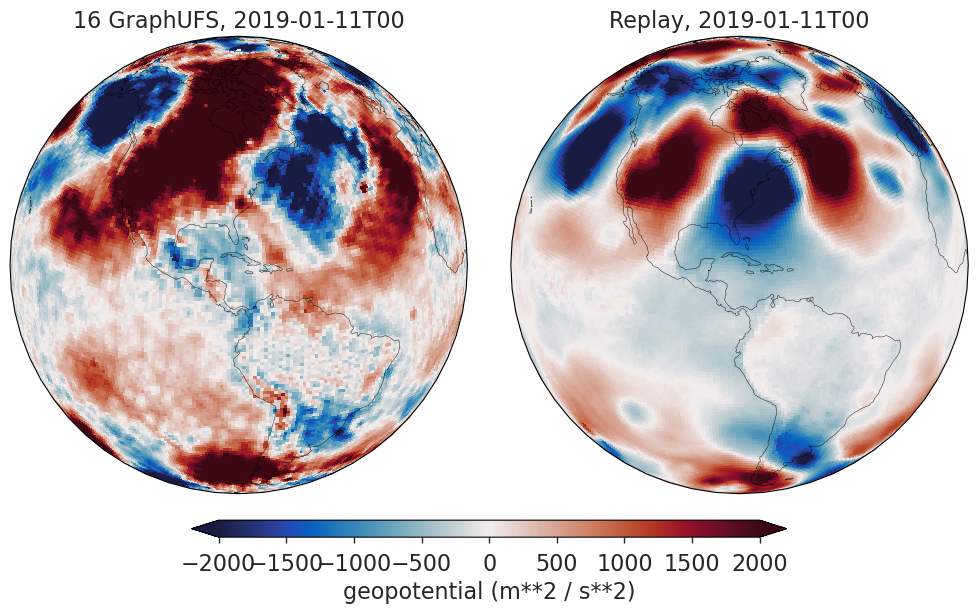

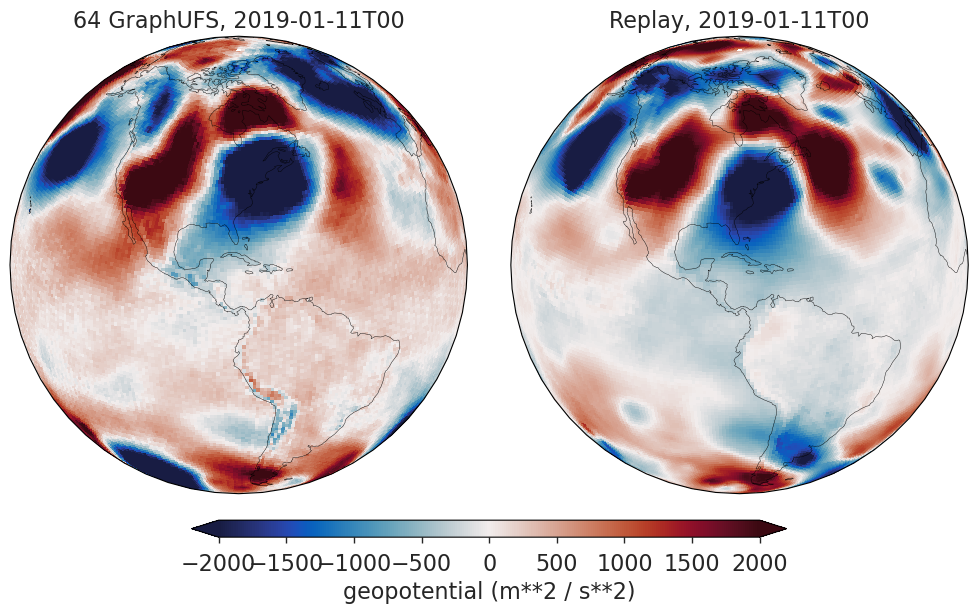

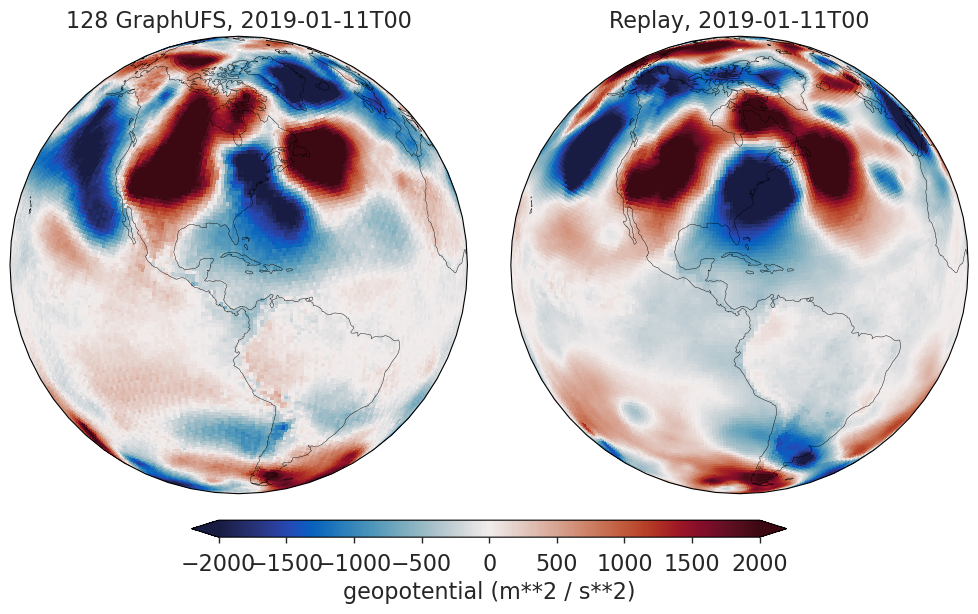

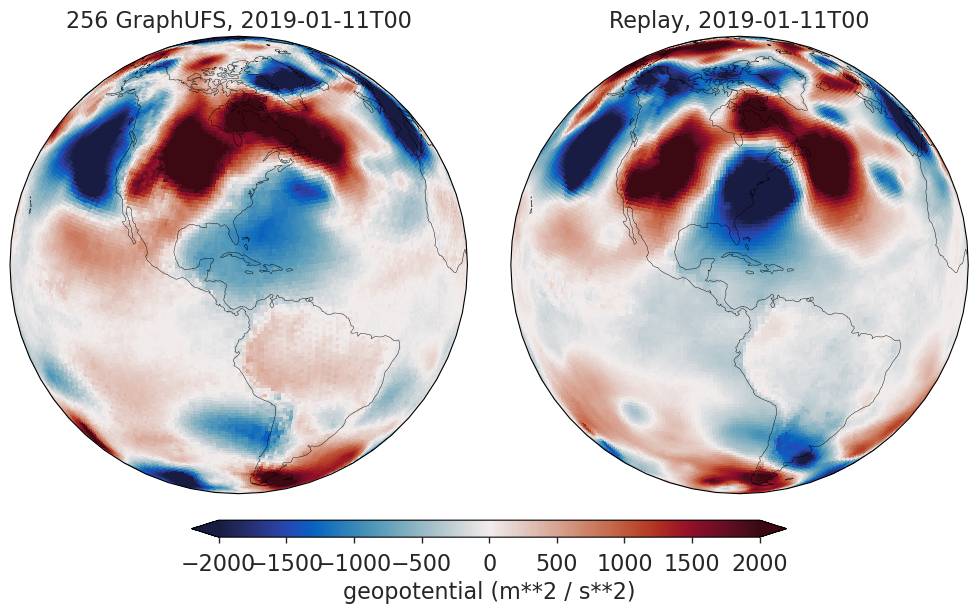

In [42]:
date = "2019-01-01T00"

#gkey = "pressfc"
#ekey = "surface_pressure"
#kw = {
#    "cmap": "cmo.balance",
#    "vmin": -2000,
#    "vmax": 2000
#}

gkey = "geopotential"
ekey = gkey
kw = {
    "cmap": "cmo.balance",
    "vmin": -2000,
    "vmax": 2000
}
level = 500


#gkey = "ugrd10m"
#ekey = "10m_u_component_of_wind"
#kw = {"cmap": "cmo.balance", "vmin": -20, "vmax": 20}

#for fhr in [24, 24*2, 24*3, 24*4]:#, 24 * 4, 24 * 6, 24 * 10, 24 * 15, 24 * 20, 24 * 30, 24 * 40, 24 * 60, 24 * 80]:
for fhr in [24, 24*5, 24*7, 24*10]:
    for latent_size in gds.latent_size.values:

        time = pd.Timestamp(date) + pd.Timedelta(hours=fhr)
        plotme = gds[gkey].sel(time=time, latent_size=latent_size)
        base = rds[gkey].sel(time=date)
        if "level" in plotme.dims:
            plotme = plotme.sel(level=level, method="nearest")
            base = base.sel(level=level, method="nearest")
        plotme -= base

        eplotme = rds[ekey].sel(time=[time])
        ebase = rds[ekey].sel(time=date)
        if "level" in eplotme.dims:
            eplotme = eplotme.sel(level=level, method="nearest")
            ebase = ebase.sel(level=level, method="nearest")
        eplotme -= ebase
        eplotme = eplotme.rename({"lon": "longitude", "lat": "latitude"})
        fig, axs = mapper.plot(
            plotme,
            eplotme,
            **kw
        )
        axs[0].set(title=f"{latent_size} "+axs[0].get_title())
        axs[1].set(title=axs[1].get_title().replace("ERA5", "Replay"))
        if "level" in gds[gkey].dims:
            fname = f"figures/graphufs{latent_size:03d}_and_replay_{gkey}_{level:04d}hpa_{fhr:03d}h.jpeg"
        else:
            fname = f"figures/graphufs{latent_size:03d}_and_replay_{gkey}_{fhr:03d}h.jpeg"
        fig.savefig(fname, bbox_inches="tight", dpi=300)